In [ ]:
# !git clone https://github.com/open-mmlab/mmdetection.git
# !pip install mmdetection/
# # Check MMDetection installation
# import mmdet
# print(mmdet.__version__)

In [2]:
# install packages

!pip install ../input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0/
!pip install ../input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
!pip install ../input/mmdetection-v280/src/addict-2.4.0-py3-none-any.whl
!pip install ../input/mmdetection-v280/src/yapf-0.30.0-py2.py3-none-any.whl
!pip install ../input/mmdetection-v280/src/mmcv_full-1.2.6-cp37-cp37m-manylinux1_x86_64.whl

Processing /kaggle/input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0
  Created wheel for mmdet: filename=mmdet-2.8.0-py3-none-any.whl size=502141 sha256=1b672c98776328b39eef963bc426f81c4f77c6344f5476394b087e35a6df71e3
  Stored in directory: /root/.cache/pip/wheels/ae/ca/90/3616110259678ffe2ef41fd1470981d081a340886954465c71
Successfully built mmdet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272907 sha256=6e658c0dc6a0332ae7c7797783417896d3817892e9801d66ac2a939837aed06d
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Processing /kaggle/input/mmdetection-v

In [3]:
from itertools import groupby
from pycocotools import mask as mutils
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [4]:
exp_name = "v3"
conf_name = "mask_rcnn_s101_fpn_syncbn-backbone+head_mstrain_1x_coco"
cell_mask_dir = '../input/hpa-mask/hpa_cell_mask'    
ROOT = '../input/hpa-single-cell-image-classification/'
train_or_test = 'train'
img_dir = f'../work/mmdet_{exp_name}_{train_or_test}'
!mkdir -p {img_dir}
df = pd.read_csv(os.path.join(ROOT, 'train.csv'))

# this script takes more than 9hours for full data.
debug = True
if debug:
    df = df[:4]

# helper funcs

In [5]:
# convert segmentation mask image to run length encoding
MAX_GREEN = 64 # filter out dark green cells
def get_rles_from_mask(image_id, class_id):
    mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    if class_id != '18':
        green_img = read_img(image_id, 'green')
    rle_list = []
    mask_ids = np.unique(mask)
    for val in mask_ids:
        if val == 0:
            continue
        binary_mask = np.where(mask == val, 1, 0).astype(bool)
        if class_id != '18':
            masked_img = green_img * binary_mask
            #print(val, green_img.max(),masked_img.max())
            if masked_img.max() < MAX_GREEN:
                continue
        rle = coco_rle_encode(binary_mask)
        rle_list.append(rle)
    return rle_list, mask.shape[0], mask.shape[1]

def coco_rle_encode(mask):
    rle = {'counts': [], 'size': list(mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

# mmdet custom dataset generator
def mk_mmdet_custom_data(image_id, class_id):
    rles, height, width = get_rles_from_mask(image_id, class_id)
    if len(rles) == 0:
        return {
            'filename': image_id+'.jpg',
            'width': width,
            'height': height,
            'ann': {}
        }
    rles = mutils.frPyObjects(rles, height, width)
    bboxes = mutils.toBbox(rles)
    bboxes[:, 2] += bboxes[:, 0]
    bboxes[:, 3] += bboxes[:, 1]
    return {
        'filename': image_id+'.jpg',
        'width': width,
        'height': height,
        'ann':
            {
                'bboxes': np.array(bboxes, dtype=np.float32),
                'labels': np.zeros(len(bboxes)), # dummy data.(will be replaced later)
                'masks': rles
            }
    }

# print utility from public notebook
def print_masked_img(image_id, mask):
    img = load_RGBY_image(image_id, train_or_test)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.6)
    plt.title('Image + Mask')
    plt.axis('off')
    plt.show()
    
# image loader, using rgb only here
def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    red = read_img(image_id, "red", train_or_test, image_size)
    green = read_img(image_id, "green", train_or_test, image_size)
    blue = read_img(image_id, "blue", train_or_test, image_size)
    #yellow = read_img(image_id, "yellow", train_or_test, image_size)
    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images

# 
def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
#     if img.max() > 255:
#         img_max = img.max()
#         img = (img/255).astype('uint8')
#     return img
    if img.dtype == 'uint16':
        img = (img/256).astype('uint8')
    return img

# make annotation helper called multi processes
def mk_ann(idx):
    image_id = df.iloc[idx].ID
    class_id = df.iloc[idx].Label
    anno = mk_mmdet_custom_data(image_id, class_id)
    img = load_RGBY_image(image_id, train_or_test)
    cv2.imwrite(f'{img_dir}/{image_id}.jpg', img)
    return anno, idx, image_id

# checking segment mask
To extract the each cells, [CellSegmentator](https://github.com/CellProfiling/HPA-Cell-Segmentation) can be used.
And The extracted segment masks are stored in [this dataset](https://www.kaggle.com/its7171/hpa-mask).

This mask files are made as follows:
<pre>
nucl_mask, cell_mask = segmentCell(im, segmentator)
np.savez_compressed(f'{cell_dir}/{image_id}', cell_mask)
np.savez_compressed(f'{nucl_dir}/{image_id}', nucl_mask)
</pre>
So you can load the mask as follows:
<pre>
cell_mask = np.load(f'{cell_dir}/{image_id}.npz')['arr_0']
nucl_mask = np.load(f'{nucl_dir}/{image_id}.npz')['arr_0']
</pre>


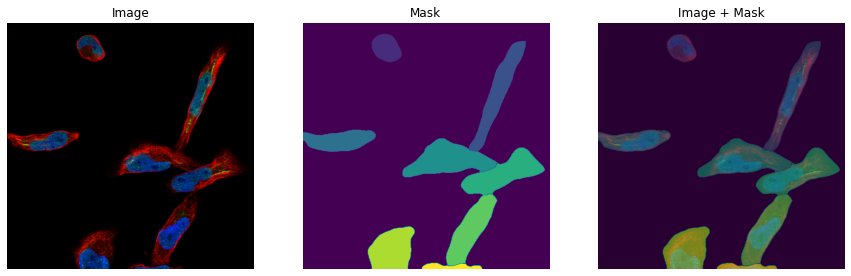

In [6]:
cell_mask_dir = '../input/hpa-mask/hpa_cell_mask'    
for idx in range(1):
    image_id = df.iloc[idx].ID
    cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
    print_masked_img(image_id, cell_mask)

# generate data for mmdetection training

In [7]:
# this part would take several hours, depends on your CPU power.
MAX_THRE = 4 # set your avarable CPU count.
p = Pool(processes=MAX_THRE)
annos = []
len_df = len(df)
for anno, idx, image_id in p.imap(mk_ann, range(len(df))):
    if len(anno['ann']) > 0:
        annos.append(anno)
    print(f'{idx+1}/{len_df}, {image_id}')

1/4, 5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0
2/4, 5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0
3/4, 60b57878-bb99-11e8-b2b9-ac1f6b6435d0
4/4, 5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0


In [8]:
lbl_cnt_dict = df.set_index('ID').to_dict()['Label']
trn_annos = []
val_annos = []
val_len = int(len(annos)*0.01)
for idx in range(len(annos)):
    ann = annos[idx]
    filename = ann['filename'].replace('.jpg','').replace('.png','')
    label_ids = lbl_cnt_dict[filename]
    len_ann = len(ann['ann']['bboxes'])
    bboxes = ann['ann']['bboxes']
    masks = ann['ann']['masks']
    # asign image level labels to each cells
    for cnt, label_id in enumerate(label_ids.split('|')):
        label_id = int(label_id)
        if cnt == 0:
            ann['ann']['labels'] = np.full(len_ann, label_id)
        else:
            ann['ann']['bboxes'] = np.concatenate([ann['ann']['bboxes'],bboxes])
            ann['ann']['labels'] = np.concatenate([ann['ann']['labels'],np.full(len_ann, label_id)])
            ann['ann']['masks'] = ann['ann']['masks'] + masks    
    if idx < val_len:
        val_annos.append(ann)
    else:
        trn_annos.append(ann)

In [9]:
with open(f'../work/mmdet_{exp_name}_full.pkl', 'wb') as f:
    pickle.dump(annos, f)
with open(f'../work/mmdet_{exp_name}_trn.pkl', 'wb') as f:
    pickle.dump(trn_annos, f)
with open(f'../work/mmdet_{exp_name}_val.pkl', 'wb') as f:
    pickle.dump(val_annos, f)

# training

In [10]:
from mmcv import Config
cfg = Config.fromfile('../input/mmdetection-v280/mmdetection/configs/hpa_v3/mask_rcnn_r50_fpn_1x_coco.py')

In [12]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'CustomDataset'
cfg.data_root = '../work/'

cfg.data.test.ann_file = '../work/mmdet_v3_tst.pkl'
cfg.data.test.img_prefix = '../work/mmdet_v3_test/'

cfg.data.train.ann_file = '../work/mmdet_v3_trn.pkl'
cfg.data.train.img_prefix = '../work/mmdet_v3_train/'

cfg.data.val.ann_file = '../work/mmdet_v3_val.pkl'
cfg.data.val.img_prefix = '../work/mmdet_v3_train/'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 19

# cfg.img_norm_cfg.mean = [123.68, 116.779, 103.939]
# cfg.img_norm_cfg.std = [58.393, 57.12, 57.375]
# cfg.train_pipeline[1] = dict(type:'LoadAnnotations', with_bbox: True, with_mask: True)
# cfg.train_pipeline[2]['img_scale'] = [(1333, 1333), (1280, 1280), (1024, 1024)]
# cfg.train_pipeline[3].flip_ratio = 0.5
# cfg.train_pipeline[4].mean = [123.68, 116.779, 103.939]
# cfg.train_pipeline[4].std = [58.393, 57.12, 57.375]

# lr for 8gpus = 0.02
cfg.optimizer = dict(type='SGD', lr=0.0025, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

cfg.evaluation = dict(interval=1000)

cfg.log_config.interval = 1

# Set up working dir to save files and logs.
cfg.work_dir = './work_dir'

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [14]:
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='MaskRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type=

In [13]:
import mmcv
import os.path as osp
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector( cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/opt/conda/lib/python3.7/site-packages/mmdet/datasets/custom.py:154: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2021-05-23 11:17:45,690 - mmdet - INFO - load model from: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2021-05-23 11:17:49,824 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-05-23 11:17:53,936 - mmdet - INFO - Start running, host: root@36a5bcb6af67, work_dir: /kaggle/working/work_dir
2021-05-23 11:17:53,937 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs
2021-05-23 11:18:01,877 - mmdet - INFO - Epoch [1][1/2]	lr: 2.500e-06, eta: 0:02:56, time: 7.694, data_time: 6.700, memory: 5022, loss_rpn_cls: 0.6991, loss_rpn_bbox: 0.1615, loss_cls: 3.3012, acc: 0.3906, loss_bbox: 0.0447, loss_mask: 0.9671, loss: 5.1737
2021-05-23 11:18:02,444 - mmdet - INFO - Epoch [1][2/2]	lr: 7.495e-06, eta: 0:01:32, time: 0.704, data_time: 0.252, memory: 5306, loss_rpn_cls: 0.7016, loss_rpn_bbox: 0.1156, loss_cls: 3.4110, acc: 0.3906, loss_bbox: 0.0099, loss_mask: 1.3377, loss: 5.5758
2021-05-23 11:18:02,484 - mmdet - INFO - Saving checkpoint at 1 epochs
2021-05-23 11:18:10,362 - mmdet - INFO - Epoch [2][1/2]	lr: 1.

# training for syncBN config

In [ ]:
!rsync -a ../input/mmdetection-v280/mmdetection ../
# Override Duc's config for syncBN
# !rsync -a ../input/mmdet-train-pkl/schedule_1x.py ../mmdetection/configs/hpa_v3/
# !rsync -a ../input/mmdet-train-pkl/default_runtime.py ../mmdetection/configs/hpa_v3/
# !rsync -a ../input/mmdet-train-pkl/hpa_instance.py ../mmdetection/configs/hpa_v3/

In [ ]:
config = f'configs/hpa_{exp_name}/{conf_name}.py'
# using --no-validate to avoid some errors for custom dataset metrics
additional_conf = '--no-validate --cfg-options'
additional_conf += f' work_dir=../working/work_dir'
additional_conf += f' optimizer.lr=0.0025'
cmd = f'bash -x tools/dist_train.sh {config} 1 {additional_conf}'
!cd ../mmdetection; {cmd}

In [ ]:
!ls -Rl .